In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import confusion_matrix, classification_report
import string
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
tf.debugging.set_log_device_placement(True)

# Create a simple operation to see if tf running on gpu
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.matmul(a, a)

print(b)

In [8]:
df1 =pd.read_csv("raw_partner_headlines.csv")

In [9]:
df = df1

In [5]:
df.drop(columns=["url", "publisher", "date", "stock", "Unnamed: 0"], inplace=True)

In [6]:
df.shape

(1845559, 1)

In [7]:
df.head()

,headline
0,Agilent Technologies Announces Pricing of $5……...
1,Agilent (A) Gears Up for Q2 Earnings: What's i...
2,J.P. Morgan Asset Management Announces Liquida...
3,"Pershing Square Capital Management, L.P. Buys ..."
4,Agilent Awards Trilogy Sciences with a Golden ...


## preprocess function
- tokenize text
- convert to lowercase
- prepare the set of stop words
- remove the punctuation from each token
- remove the remaining tokens that are not alphabetic
- filter out stop words
- rejoin words back to a single string

In [8]:
import re
import multiprocessing as mp
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

In [9]:
word_tokenize(df['headline'][0])

['Agilent',
 'Technologies',
 'Announces',
 'Pricing',
 'of',
 '$',
 '5……',
 'Million',
 'of',
 'Senior',
 'Notes']

In [ ]:
nltk.download('stopwords')

In [10]:
def preprocess(text):
    
    text = text.lower()

    # remove punctuations and numbers 
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) #when we remove apostrophe, is it replaced by a white space

    # remove all single characters and replace it by a space
    text = re.sub(r'\s+', ' ', text)

    # remove stopwords
    stop_words = stopwords.words('english')
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')

    text = pattern.sub('', text)
    return text



In [ ]:
for i in range(10):
    print(df['headline'][i])
    print(preprocess(df['headline'][i]))

In [31]:
# Function to apply the cleaning in parallel
# def parallel_apply_clean(data, num_cores):
#     data_split = np.array_split(data, num_cores)
#     pool = Pool(num_cores)
#     result = pd.concat(pool.map(clean_text_list, data_split))
#     pool.close()
#     pool.join()
#     return result
# def clean_text_list(text_list):
#     return text_list.apply(clean_text)
# Apply cleaning function in parallel
# if __name__ == '__main__':
#     num_cores = cpu_count()
    
#     # Apply the parallel cleaning
#     df['processed_headline'] = parallel_apply_clean(df['headline'], num_cores)

#     print(df.head())

In [20]:
df = df.drop_duplicates()

In [14]:
df_small = df.sample(n=1000)

In [15]:
df_small.head()

,headline
269694,Clear Channel Outdoor Holdings' (CCO) CEO Rich...
565080,A Review Of Master Limited Partnerships
306951,Cramer's 'Mad Money' Recap: Tomorrow Is Anothe...
223788,QLogic Still Leads the Pack - Analyst Blog
515926,Syneron Medical (ELOS) Q4 2014 Results - Earni...


In [29]:
df['headline'] = df['headline'].apply(preprocess)

C:\Users\Hhalo\AppData\Local\Temp\ipykernel_1824\786165565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['headline'] = df['headline'].apply(preprocess)


In [32]:
dfCOPY = df.copy()

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#vader lexicon to analyze sentiment
nltk.download('vader_lexicon')
def categorize_headline(headline):
    sentiment_score = sia.polarity_scores(headline)['compound'] 
    if sentiment_score > 0.09:
        return "Positive"
    elif sentiment_score < -0.09:
        return "Negative"
    else:
        return "Neutral"

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hhalo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:
sentiment = [categorize_headline(headline) for headline in df["headline"]] #analyze sentiment for each headline from nltk and add to df
df["sentiment"] = sentiment
df.head()

C:\Users\Hhalo\AppData\Local\Temp\ipykernel_1824\880753655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = sentiment


,headline,label,sentiment
0,agilent technologies announces pricing million...,Neutral,Neutral
1,agilent gears earnings cards,Neutral,Neutral
2,j morgan asset management announces liquidatio...,Positive,Positive
3,pershing square capital management p buys agil...,Neutral,Neutral
4,agilent awards trilogy sciences golden ticket ...,Positive,Positive


In [40]:
df.drop(columns='sentiment',inplace=True)
df.head()

C:\Users\Hhalo\AppData\Local\Temp\ipykernel_1824\2593565911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='label',inplace=True)


,headline,sentiment
0,agilent technologies announces pricing million...,Neutral
1,agilent gears earnings cards,Neutral
2,j morgan asset management announces liquidatio...,Positive
3,pershing square capital management p buys agil...,Neutral
4,agilent awards trilogy sciences golden ticket ...,Positive


<Axes: xlabel='sentiment', ylabel='count'>

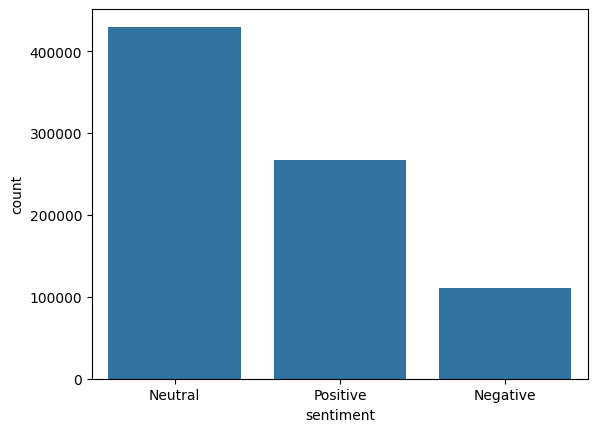

In [44]:
import seaborn as sns
sns.countplot(x='sentiment', data=df)

In [45]:
df.value_counts('sentiment')

sentiment
Neutral     429900
Positive    266575
Negative    110523
Name: count, dtype: int64

### ensure balance in sentiment

In [49]:
# get lowest count (negative based on figure above), so we can match the other sentiments and balance the dataset
neg_count = df['sentiment'].value_counts()['Negative']
# make sure samples are random
pos_sample = df[df['sentiment'] == 'Positive'].sample(n=neg_count, random_state=1)
neutral_sample = df[df['sentiment'] == 'Neutral'].sample(n=neg_count, random_state=1)

# use all negative samples since it is the lowest number
neg_sample = df[df['sentiment'] == 'Negative']

# concatonate and balance and shuffle
balanced_df = pd.concat([pos_sample, neutral_sample, neg_sample])
df = balanced_df.sample(frac=1).reset_index(drop=True)
df['sentiment'].value_counts() # nice

sentiment
Neutral     110523
Positive    110523
Negative    110523
Name: count, dtype: int64

In [53]:
# shuffle dataframe again and reset index
df = df.sample(frac=1).reset_index(drop=True)
df_IMPORTANT = df.copy()

# CHECKPOINT PROCESSED AND BALANCED DATA! WILL EMBED MANUALLY NOW TO CREATE WEIGHTS IN A VECTOR SPACE

In [10]:
# we will create percentile length of headline based on average length 
df['headline_len'] = df['headline'].apply(len)
average_length = df['headline_len'].mean()
percentile_len = df['headline_len'].quantile(0.85)
df = df.drop(columns=['headline_len'])

In [11]:
percentile_len

78.0

In [57]:
# one hot encoder, text vectorization
one_hot_encoder = OneHotEncoder(
    sparse_output=False
)

text_vectorization = TextVectorization(
    max_tokens=68000,
    output_sequence_length=int(percentile_len)
)

In [60]:
# training, validation, testing
X_train, X_temp, y_train, y_temp = train_test_split(df["headline"], df["sentiment"], test_size=0.2, stratify=df["sentiment"], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
X_train[:1]

76664    fda grants exemption cellectar import alert cl...
Name: headline, dtype: object

In [99]:
# one hot encoding y 
y_train_encoded = one_hot_encoder.fit_transform(
    y_train.to_numpy().reshape(-1, 1)
)
y_val_encoded = one_hot_encoder.transform(
    y_val.to_numpy().reshape(-1, 1)
)
y_test_encoded = one_hot_encoder.transform(
    y_test.to_numpy().reshape(-1, 1)
)
y_train_encoded

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [101]:
one_hot_encoder.categories_

[array(['Negative', 'Neutral', 'Positive'], dtype=object)]

In [63]:
from tensorflow.keras import layers
# adapt vectorization
text_vectorization.adapt(X_train)
text_vocab = text_vectorization.get_vocabulary()
token_embed = layers.Embedding(
    input_dim=len(text_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding"
)

In [64]:
# model:
inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
text_vectors = text_vectorization(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 66)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 66, 128)          6306560   
                                                                 
 conv1d (Conv1D)             (None, 66, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 output_layer (Dense)        (None, 3)                 195   

In [66]:
# model checkpoint callback, not my own idea: credit : https://www.youtube.com/watch?v=oWo9SNcyxl
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=0,
        save_best_only=True,
        monitor='val_loss'
    )

In [67]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [68]:
# model fit with callback
history = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=5,
    callbacks=[create_model_checkpoint("news_sentiment_model")]
)

Epoch 1/5
8282/8290 [============================>.] - ETA: 0s - loss: 0.1231 - accuracy: 0.9611

INFO:tensorflow:Assets written to: model_experiments\news_sentiment_model\assets


INFO:tensorflow:Assets written to: model_experiments\news_sentiment_model\assets


8290/8290 [==============================] - 57s 6ms/step - loss: 0.1231 - accuracy: 0.9611 - val_loss: 0.0567 - val_accuracy: 0.9837
Epoch 2/5
8284/8290 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9903

INFO:tensorflow:Assets written to: model_experiments\news_sentiment_model\assets


INFO:tensorflow:Assets written to: model_experiments\news_sentiment_model\assets


8290/8290 [==============================] - 46s 6ms/step - loss: 0.0314 - accuracy: 0.9903 - val_loss: 0.0551 - val_accuracy: 0.9841
Epoch 3/5
8290/8290 [==============================] - 46s 6ms/step - loss: 0.0127 - accuracy: 0.9958 - val_loss: 0.0630 - val_accuracy: 0.9848
Epoch 4/5
8290/8290 [==============================] - 45s 5ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.0707 - val_accuracy: 0.9857
Epoch 5/5
8290/8290 [==============================] - 45s 5ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0845 - val_accuracy: 0.9852


1037/1037 [==============================] - 6s 6ms/step - loss: 0.0546 - accuracy: 0.9835
Test loss: 0.0546, Test accuracy: 0.9835329055786133

1037/1037 [==============================] - 3s 3ms/step

              precision    recall  f1-score   support

    Negative       0.99      0.98      0.98     11052
     Neutral       0.98      0.98      0.98     11053
    Positive       0.98      0.99      0.99     11052

    accuracy                           0.98     33157
   macro avg       0.98      0.98      0.98     33157
weighted avg       0.98      0.98      0.98     33157



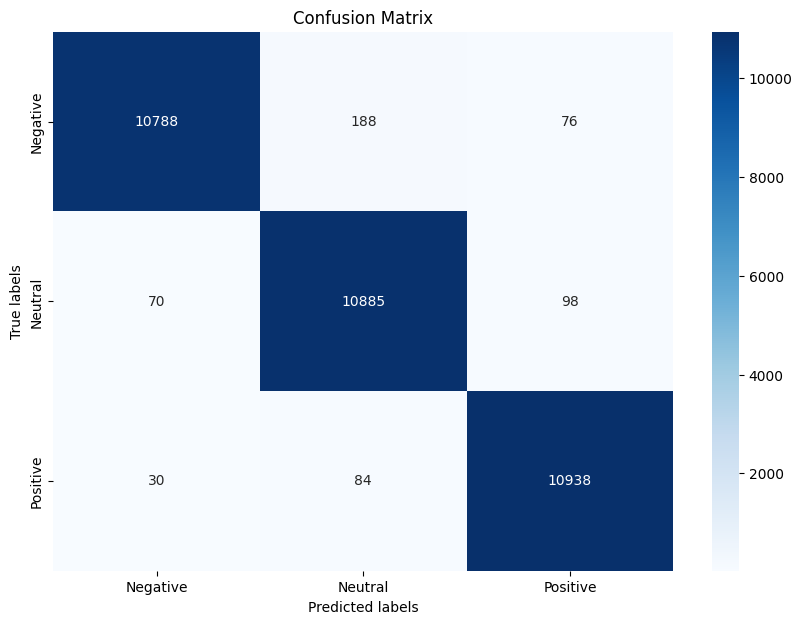

In [70]:
# evaluating model on test set, making predictions, creating and plotting confusion matrix (with sns)
import matplotlib.pyplot as plt
best_model_path = os.path.join("model_experiments", "news_sentiment_model")
model.load_weights(best_model_path)

test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc}\n")

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test_encoded, axis=1)

report = classification_report(
    true_classes, predicted_classes,
    target_names=one_hot_encoder.categories_[0]
)
print()
print(report)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=one_hot_encoder.categories_[0], yticklabels=one_hot_encoder.categories_[0])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show();

In [102]:
# negative, neutral, positive
d = preprocess('A man was killed in a Cybertruck crash in Texas early Monday morning.')
pred = model.predict([[d]])
pred

1/1 [==============================] - 0s 48ms/step


array([[9.9998987e-01, 1.0157097e-05, 5.2974464e-10]], dtype=float32)

In [89]:
model.save('')

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets
